# Müşteri Segmentasyonu ve Davranış Analizi Projesi

Bu çalışmanın amacı, kredi kartı müşterilerini işlem hacmi ve sıklığına göre segmentlere ayırmak, bu segmentlerin şirket terk (churn) risklerini analiz etmek ve demografik özelliklerin (Eğitim, Cinsiyet) harcama alışkanlıkları üzerindeki etkisini incelemektir.

**Analiz Adımları:**
1. Veri Hazırlığı ve Özellik Mühendisliği
2. K-Means ile Müşteri Segmentasyonu (RFM Temelli)
3. Segmentlerin Görselleştirilmesi ve Profil Analizi
4. Churn (Terk) Oranlarının Segment Bazlı İncelenmesi
5. Demografik Analizler (Eğitim & Cinsiyet)

In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Görselleştirme Ayarları
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid") # Arka planı daha temiz yapar
plt.rcParams.update({'figure.figsize': (12, 6), 'figure.dpi': 120})

# Veriyi Oku (Dosya yolunu kendi bilgisayarına göre güncellemelisin)
# dosya_yolu = r"C:\Users\Fatih\Downloads\BankChurners.csv"
# Eğer aynı klasördeyse direkt ismini yazabilirsin:
dosya_yolu = r"C:\Users\Fatih\Downloads\BankChurners.csv"
df = pd.read_csv(dosya_yolu)

# Gereksiz son iki sütunu at (Naive Bayes sütunları genellikle gereksizdir)
df = df.iloc[:, :-2]

# Churn Etiketini Sayısallaştırma (1: Terk Eden, 0: Kalan)
df["Churn"] = df["Attrition_Flag"].apply(lambda x: 1 if x == "Attrited Customer" else 0)

print("Veri Seti Başarıyla Yüklendi. Boyut:", df.shape)
df.head(3)

Veri Seti Başarıyla Yüklendi. Boyut: (10127, 22)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0


In [2]:
# --- 1. Veri Hazırlığı ---
X = df[["Total_Trans_Amt", "Total_Trans_Ct"]]
sc = MinMaxScaler((0, 1))
X_scaled = sc.fit_transform(X)

# --- 2. K-Means Modelleme ---
kmeans = KMeans(n_clusters=4, random_state=42)
df["Segment_No"] = kmeans.fit_predict(X_scaled)

# --- 3. Segment İsimlendirme (Otomatik Skorlama) ---
# Segmentleri harcama ve sıklık ortalamasına göre sıralayıp isimlendiriyoruz
seg_summary = df.groupby("Segment_No")[["Total_Trans_Amt", "Total_Trans_Ct"]].mean()
seg_summary["Score"] = seg_summary["Total_Trans_Amt"] + seg_summary["Total_Trans_Ct"]
seg_summary = seg_summary.sort_values("Score")

# Düşükten yükseğe isim atama
segment_names = ["Bronze", "Silver", "Gold", "Diamond"]
mapping = {idx: name for idx, name in zip(seg_summary.index, segment_names)}
df["Segment_Name"] = df["Segment_No"].map(mapping)

print("Segmentler oluşturuldu ve isimlendirildi:")
print(df["Segment_Name"].value_counts())

Segmentler oluşturuldu ve isimlendirildi:
Segment_Name
Silver     5008
Bronze     3665
Diamond     747
Gold        707
Name: count, dtype: int64


## 1. Müşteri Segmentasyon Haritası

Müşterileri **Toplam İşlem Adedi (Frequency)** ve **Toplam Harcama Tutarı (Monetary)** eksenlerinde incelediğimizde 4 ana küme net bir şekilde ayrışmaktadır.

* **Diamond (VIP):** Sağ üst köşede yer alan, hem çok harcayan hem de sık işlem yapan grup.
* **Bronze:** Sol alt köşede, düşük aktiviteye sahip grup.

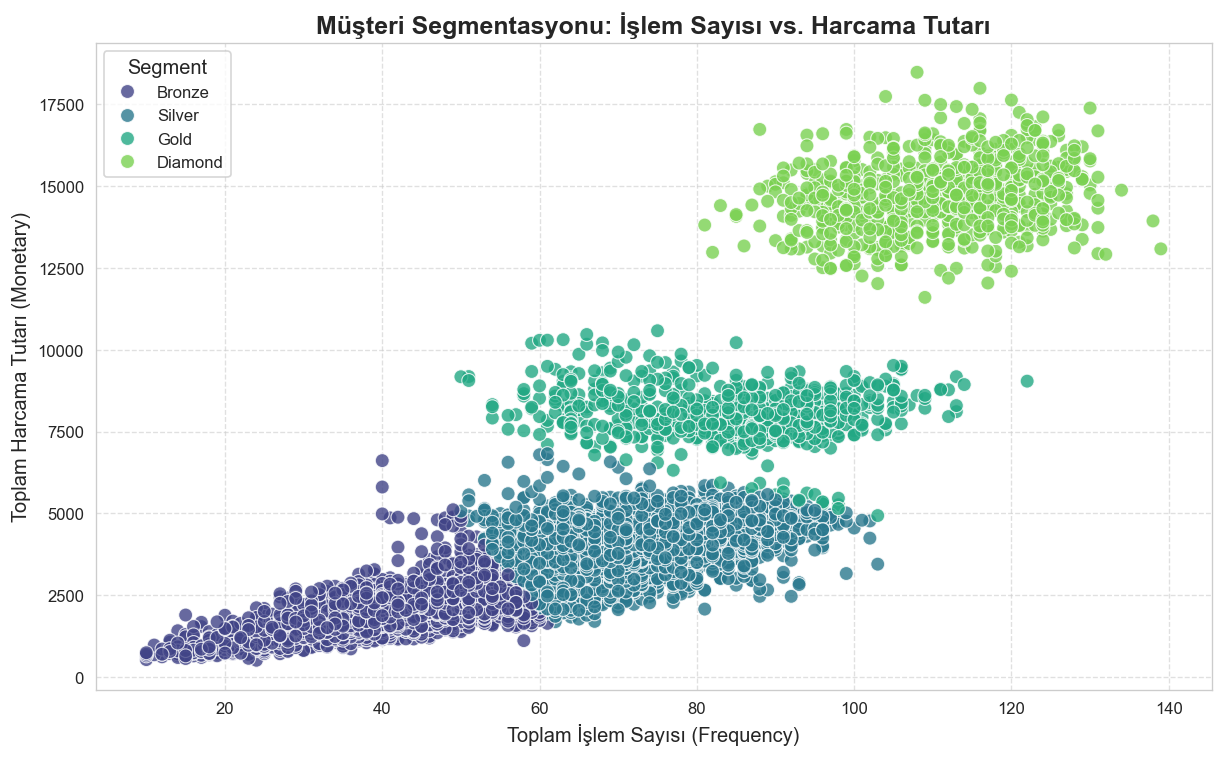

In [3]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x="Total_Trans_Ct",
    y="Total_Trans_Amt",
    hue="Segment_Name",
    data=df,
    palette="viridis",
    s=70,
    alpha=0.8,
    edgecolor="w" # Noktaların etrafına beyaz çizgi ekler, daha net görünür
)

plt.title("Müşteri Segmentasyonu: İşlem Sayısı vs. Harcama Tutarı", fontsize=15, fontweight='bold')
plt.xlabel("Toplam İşlem Sayısı (Frequency)", fontsize=12)
plt.ylabel("Toplam Harcama Tutarı (Monetary)", fontsize=12)
plt.legend(title="Segment", title_fontsize='12', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 2. Segmentlere Göre Müşteri Terk (Churn) Oranları

Hangi müşteri grubu bizi terk etmeye daha meyilli? Aşağıdaki grafik, "Bronze" ve "Gold" segmentlerindeki risk durumunu açıkça ortaya koymaktadır.

* **Bronze Segmenti:** En yüksek terk oranına sahiptir. Bu grup muhtemelen bağlılığı düşük veya yeni müşterilerden oluşmaktadır.
* **Diamond & Silver:** Neredeyse hiç kayıp verilmemiştir, sadakatleri yüksektir.

C:\Users\Fatih\AppData\Local\Temp\ipykernel_20092\2555610031.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


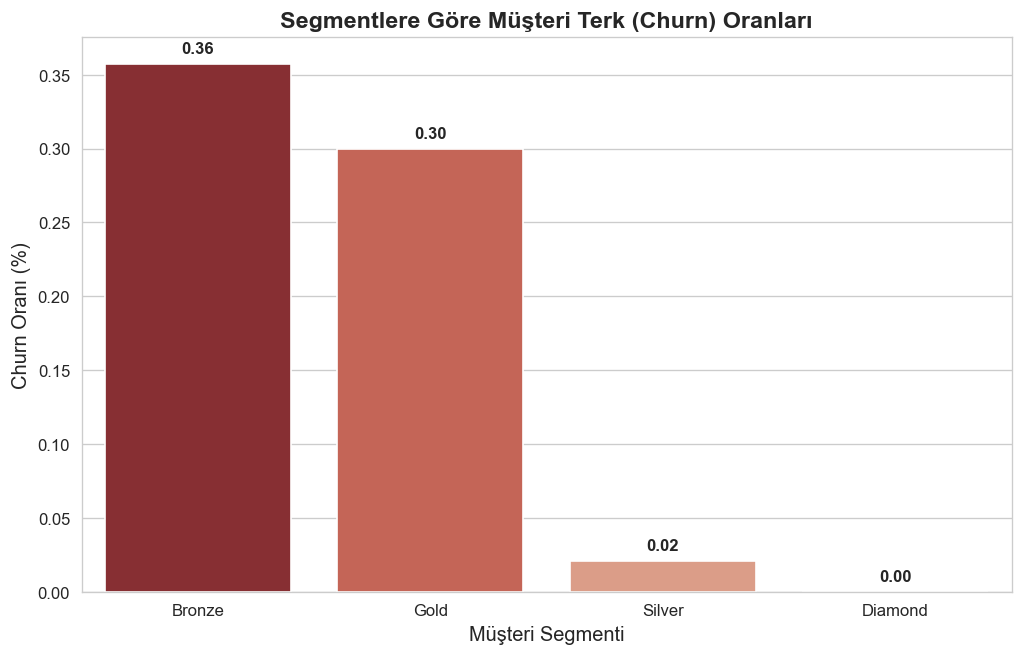

In [4]:
# Churn oranlarını hesapla
churn_rates = df.groupby('Segment_Name')['Churn'].mean().reset_index()

# Görselleştirme
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=churn_rates,
    x='Segment_Name',
    y='Churn',
    palette=['#962025', '#D65745', '#E9967A', '#F0E68C'], # Risk kırmızısı tonları
    order=["Bronze", "Gold", "Silver", "Diamond"] # Mantıksal sıralama
)

plt.title('Segmentlere Göre Müşteri Terk (Churn) Oranları', fontsize=14, fontweight='bold')
plt.ylabel('Churn Oranı (%)', fontsize=12)
plt.xlabel('Müşteri Segmenti', fontsize=12)

# Barların üzerine oranları yazdır
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points',
                     fontweight='bold')
plt.show()

## 3. Eğitim Seviyesinin Segmentlere Dağılımı

Eğitim seviyesi, müşterinin hangi segmente (VIP, Bronze vb.) gireceğini belirleyen bir faktör mü?
Aşağıdaki grafik, tüm eğitim seviyelerinde segment dağılımının benzer olduğunu (homojen yapı) göstermektedir. Yani, Doktora mezunu birinin VIP olma ihtimali, Lise mezunu biriyle benzer trendler göstermektedir.

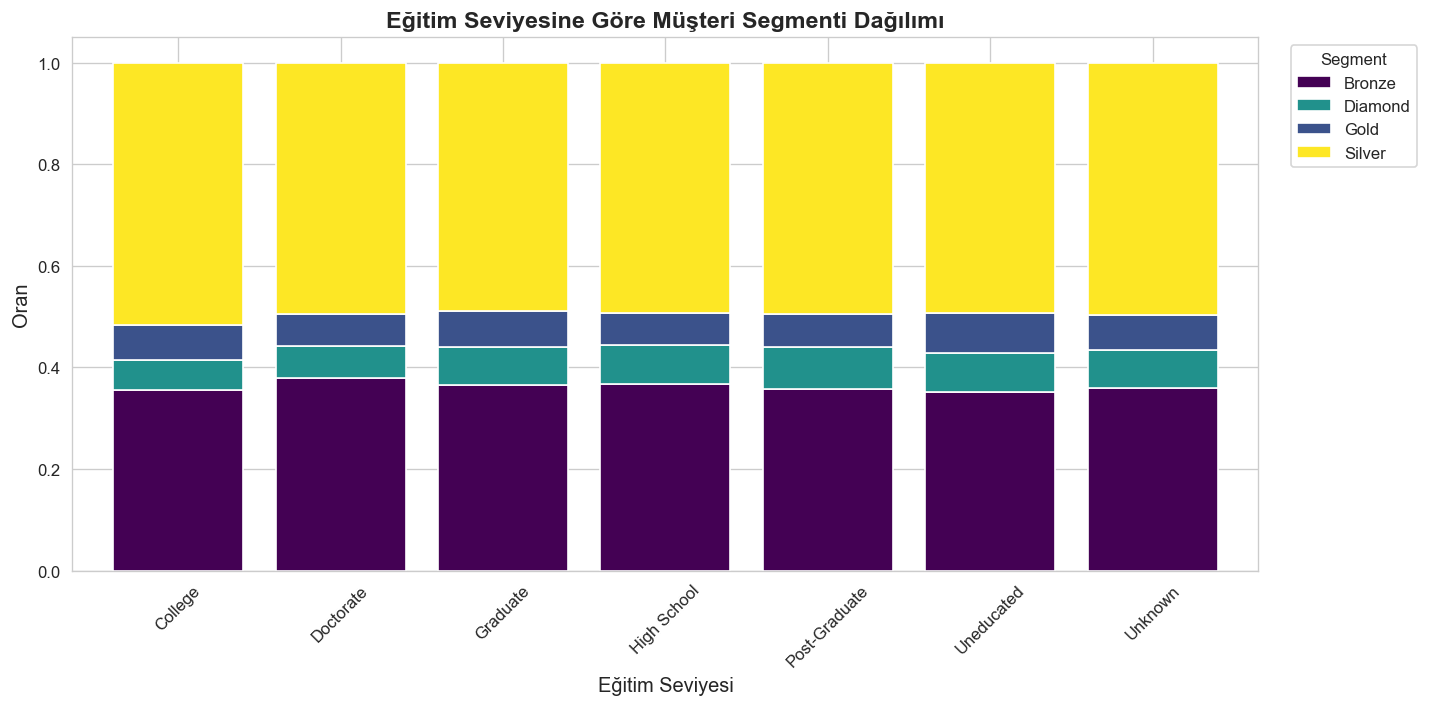

In [5]:
# Çapraz tablo oluştur (Normalizasyon ile oranlara bakıyoruz)
edu_segment = pd.crosstab(df['Education_Level'], df['Segment_Name'], normalize='index')

# Stacked Bar çizimi
edu_segment.plot(
    kind='bar',
    stacked=True,
    color=['#440154', '#21918c', '#3b528b', '#fde725'], # Viridis renkleri
    figsize=(12, 6),
    width=0.8
)

plt.title('Eğitim Seviyesine Göre Müşteri Segmenti Dağılımı', fontsize=14, fontweight='bold')
plt.ylabel('Oran', fontsize=12)
plt.xlabel('Eğitim Seviyesi', fontsize=12)
plt.legend(title='Segment', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.1. Harcama Yoğunluğu Analizi (Violin Plot)

İlk olarak, verinin yoğunluğunu (density) incelemek için **Violin (Keman) Grafiği** kullandık. Bu grafik, standart Box Plot'un aksine verinin nerede kümelendiğini daha net gösterir.

**Gözlemler:**
* Grafiğin geniş olduğu kısımler, müşterilerin en çok bulunduğu harcama aralıklarını temsil eder.
* Hem Erkek (M) hem Kadın (F) müşterilerde **2.500 - 5.000 birim** arasında yoğun bir kümelenme görülmektedir.
* Kesikli çizgiler çeyreklik (quartile) değerlerini göstermektedir; medyan değerleri birbirine oldukça yakındır.

C:\Users\Fatih\AppData\Local\Temp\ipykernel_20092\2651294516.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


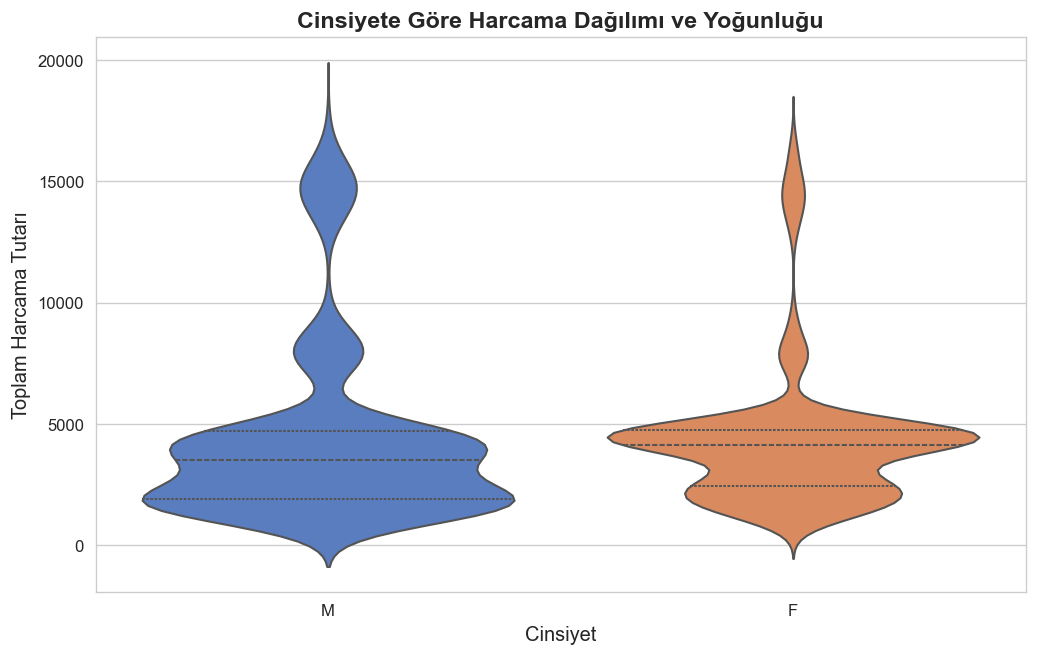

In [7]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="Gender",
    y="Total_Trans_Amt",
    data=df,
    palette="muted",
    inner="quartile" # Çeyreklik çizgilerini gösterir
)
plt.title("Cinsiyete Göre Harcama Dağılımı ve Yoğunluğu", fontsize=14, fontweight='bold')
plt.xlabel("Cinsiyet", fontsize=12)
plt.ylabel("Toplam Harcama Tutarı", fontsize=12)
plt.show()

### 4.2. Harcama Frekansları (Histogram)

Verinin normal dağılıma uyup uymadığını (Normallik Varsayımı) kontrol etmek için Histogram grafiğini inceledik.

**Gözlemler:**
* Grafikte **çift tepeli (bimodal)** bir yapı görülmektedir. Yani müşteriler genellikle ya "düşük harcayanlar" ya da "çok yüksek harcayanlar" olarak iki ana kitleye ayrılmış durumdadır.
* Bu durum, parametrik testler (T-Testi gibi) yapmadan önce verinin dikkatli incelenmesi gerektiğini veya non-parametrik testlerin (Mann-Whitney U) tercih edilebileceğini işaret eder.

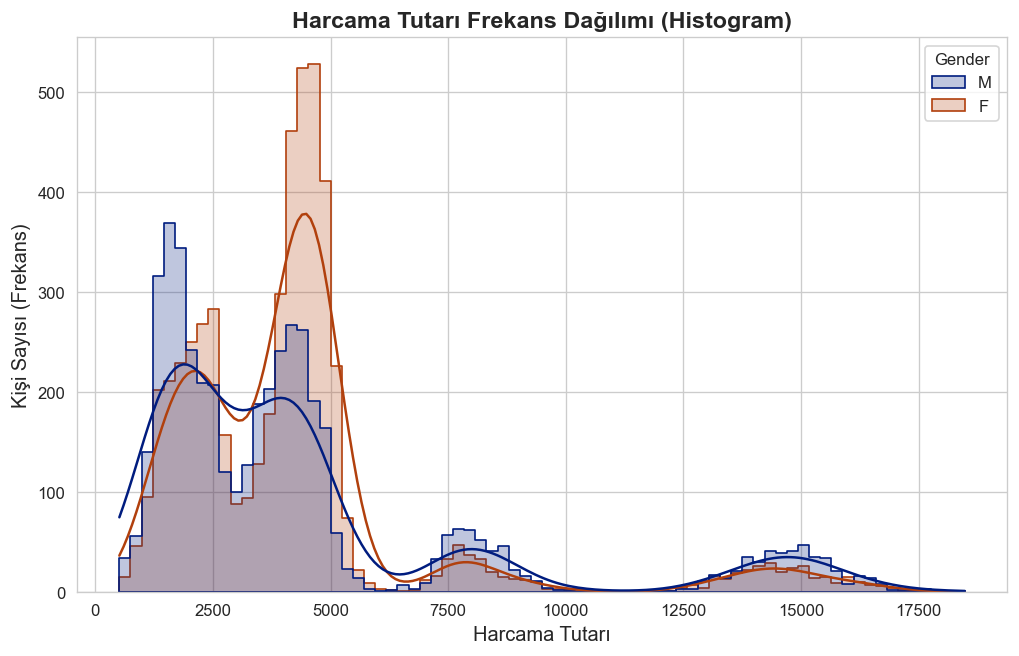

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Total_Trans_Amt",
    hue="Gender",
    kde=True,       # Yoğunluk eğrisini ekle
    element="step", # Barların iç içe geçmesini engeller, daha net görünür
    palette="dark"
)
plt.title("Harcama Tutarı Frekans Dağılımı (Histogram)", fontsize=14, fontweight='bold')
plt.xlabel("Harcama Tutarı", fontsize=12)
plt.ylabel("Kişi Sayısı (Frekans)", fontsize=12)
plt.show()

### 4.3. Ortalama Harcama Karşılaştırması (%95 Güven Aralığı)

Son olarak, iki grubun ortalama harcamalarını ve bu ortalamaların güvenilirliğini (Confidence Interval) karşılaştırdık.

**Gözlemler:**
* Siyah çubuklar (Hata Çubukları), %95 güven aralığını temsil eder.
* İki grubun hata çubukları birbiriyle kesişiyorsa, "istatistiksel olarak anlamlı bir fark yoktur" diyebiliriz.
* Burada ortalamalar birbirine çok yakındır (Kadın: ~4324, Erkek: ~4493). Bu da cinsiyetin harcama üzerinde tek başına belirleyici bir faktör olmayabileceğini düşündürmektedir.

C:\Users\Fatih\AppData\Local\Temp\ipykernel_20092\974937485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


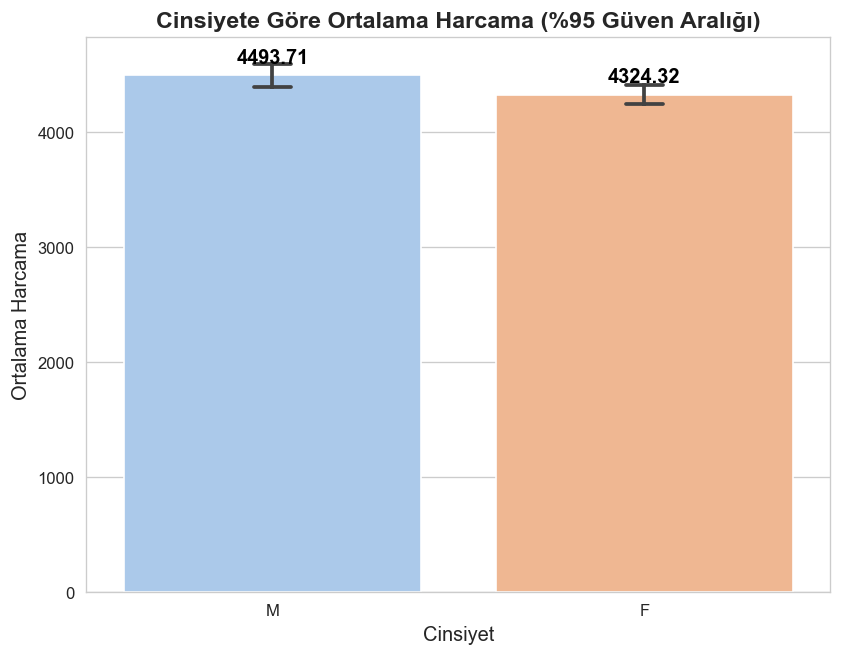

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x="Gender",
    y="Total_Trans_Amt",
    data=df,
    errorbar=('ci', 95), # %95 Güven Aralığı
    capsize=0.1,         # Hata çubuğunun şapkasını ekler
    palette="pastel"
)

# Ortalamaları barların üzerine yazdırma
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Cinsiyete Göre Ortalama Harcama (%95 Güven Aralığı)", fontsize=14, fontweight='bold')
plt.xlabel("Cinsiyet", fontsize=12)
plt.ylabel("Ortalama Harcama", fontsize=12)
plt.show()